# DenseNet-based VAD

# Дисклеймер:

Данный ноутбук изначально задумывался как черновик. Это вполне рабочая версия, которую можно натренировать и прогнать по данным и которая выдаст задуманные результаты (возможно, чуть более низкого качества, чем планировалось). Здесь присутствуют много спорных моментов и реализаций, которые я планировал исправить впоследствие в полном проекте, но, к сожалению, из-за совпавшего с этой неделей дедлайна на текущем месте работы и личных обстоятельств, я не успел закончить и натренировать нормальную версию ВАДа со всеми более правильными, по моему мнению, методами. В тексте ноутбука я буду оставлять комментарии с моими замечаниями и идеями по поводу этих методов, которые я успел реализовать. Эти идеи лежат в папке dynamic_flow, необходимые файлы буду указывать в комментариях. Практически все из них (за исключением файла с архитектурами и конфига) можно запустить по отдельности и убедиться в работоспособности их функционала.

# Датасеты


#### LibriSpeech
Для тренировки испольован раздел `dev-clean.tar.gz` http://www.openslr.org/12/.. Для использования в скрипте архив необходимо распаковать, не меняя структуры.

#### QUT-NOISE
Датасет использован целиком https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/. ДЛя использования необходимо скачать все архивы и распакаовать их в одну папку. О задании путей до них - ниже в коде

# Запуск и тренировка

Модель можно натренировать с нуля, используя вышеуказанные датасеты, можно использовать приложенный в папке models чекпойнт. О тренировке и использовании - также ниже

В ноутбуке используются глобальные переменные (капсом), с их помощью можно котролировать параметры, а так же указывать, хотим ли мы препроцессить данные, тренировать или нет модели и т.д.

# КОММЕНТАРИЙ
Сети натренированы на очень маленькой части либриспича, всего около 3000 файлов. Здесь это сделано ради сокращения времени препроцессинга данных, о котором ниже, но в идеальном мире я бы тренировал как минимум на `train-clean-360` + `train-other-500`, валидацию гонял бы по `train-clean-100`, закинув бы туда побольше шумов, например из MUSAN. 

# Рабочая директория
Директория, из которой запускаются данные и где будут храниться файлы препроцессинга

In [1]:
path_peer = r'D:\vk_test'

We can then proceed to check which directory to use. If everything goes right, you will see your path echoed in the output.

In [2]:
import os

os.chdir(path_peer)
print('Directory is set to', os.getcwd())

Directory is set to D:\vk_test


# Необходимые библиотеки.
Раскомментить, если необходимо установить.

In [3]:
# !pip install SoundFile
# !pip install webrtcvad
# !pip install pydub
# !pip install python_speech_features
# !pip install h5py
# !pip install h5py_cache

# Настройки препроцессинга

Глобальные константы

In [3]:
# реформатирование аудио
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# путь до файлов препроцессинга
DATA_FOLDER = r'D:\vk_test\data'

# Слайсинг входных данных.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Длина фрейма для лейбла.
FRAME_SIZE_MS = 10

# Слайсы по размеру фрейма.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))

# Глобальные переменные для запуска


`OBJ_PREPARE_AUDIO` - если True, то препроцессим данные, если False - используем уже сохраненные результаты препроцессинга <br/>
`OBJ_TRAIN_MODELS` - если True, то тренируем модель заново, иначе используем сохраненную.<br/>
`OBJ_CUDA` - работаем на гпу или на цпу.

In [4]:
import torch

OBJ_CUDA = torch.cuda.is_available()

OBJ_PREPARE_AUDIO = True
OBJ_TRAIN_MODELS = True

if OBJ_CUDA:
    print('CUDA has been enabled.')
else:
    print('CUDA has been disabled.')

CUDA has been enabled.


# Подготовка датасетов
Унифицирует данные (в том числе для использования с webrtc) и хранит их в hdf5 формате для быстрого доступа к любому их сегменту. Если данные уже обработаны, процесс автоматически пропускается


In [5]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import numpy as np
import webrtcvad

class FileManager:
    
    def __init__(self, name, directory):
        
        self.name = name
        self.data = h5py.File(DATA_FOLDER + '/' + name + '.hdf5', 'a')
        
        # собираем имена файлов.
        if 'files' not in self.data:
        
            # собираем сами файлы.
            files = glob.glob(directory + '/**/*.wav', recursive=True)
            files.extend(glob.glob(directory + '/**/*.flac', recursive=True))
            files = [f for f in files]
            
            # создаем файл датасета.
            dt = h5py.special_dtype(vlen=str)
            self.data.create_dataset('files', (len(files),), dtype=dt)
            
            # и добавляем имена.
            for i, f in enumerate(files):
                self.data['files'][i] = f
        
    def get_track_count(self):
        return len(self.data['files'])

    def prepare_files(self, normalize=False):
        '''
        Подготовка файлов. Конвертирует всё в WAV, съедобный для WebRTC
        (так как питоновская реализация очень капризная к формату)
        
        '''
        
        if not OBJ_PREPARE_AUDIO:
            print(f'Skipping check for {self.name}.')
            return
        
        print('Found {0} tracks to check.'.format(self.get_track_count()))
        progress = 1
        
        # датасет исходных сырых данных.
        if 'raw' not in self.data:
            dt = h5py.special_dtype(vlen=np.dtype(np.int16))
            self.data.create_dataset('raw', (self.get_track_count(),), dtype=dt)
        
        # конвертируем и сохраняем оригинал.
        for i, file in enumerate(self.data['files']):
            
            print('Processing {0} of {1}'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

            if len(self.data['raw'][i]) > 0:
                continue
 
            track = (AudioSegment.from_file(file.decode("utf-8"))
                     .set_frame_rate(SAMPLE_RATE)
                     .set_sample_width(SAMPLE_WIDTH)
                     .set_channels(SAMPLE_CHANNELS))

            if normalize:
                track = track.apply_gain(-track.max_dBFS)

            self.data['raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)
            
        self.data.flush()
        print('\nDone!')
        
    def collect_frames(self):
        '''
        Собираем все аудио в один длинный массив для последующего сэмплинга
        '''
      
        if 'frames' in self.data:
            print('Frame merging already done. Skipping.')
            return
        
        if 'raw' not in self.data:
            print('Could not find raw data!')
            return
        
        frame_count = 0
        progress = 1
        
        # считаем количество необходимых фреймов.
        for raw in self.data['raw']:
            frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
            print('Counting frames ({0} of {1})'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1
            
        # датасет для фреймов.
        dt = np.dtype(np.int16)
        self.data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)
        
        progress = 0

        buffer = np.array([])
        buffer_limit = FRAME_SIZE * 4096
        
        # мерджим.
        for raw in self.data['raw']:
            
            # падим исходные данные под длину фрейма.
            raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))
            
            buffer = np.concatenate((buffer, raw))
            
            # Добиваем буфер до полного
            if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
                continue
            
            # берем фремы из буфера.
            frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
            buffer = np.array([])
            
            # добавляем.
            self.data['frames'][progress : progress + len(frames)] = frames
            
            progress += len(frames)
            print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
            
        self.data.flush()
        print('\nDone!')
        
    def label_frames(self):
        '''
        Искусственно размечаем данные с помощью WebRTC
        '''
        
        if 'labels' in self.data:
            print('Frame labelling already done. Skipping.')
            return
        
        if 'frames' not in self.data:
            print('Could not find any frames!')
            return
        
        vad = webrtcvad.Vad(0)
        
        frame_count = len(self.data['frames'])
        progress = 0
        batch_size = 65536
        
        # датасет для лейблов.
        dt = np.dtype(np.uint8)
        self.data.create_dataset('labels', (frame_count,), dtype=dt)
        
        # считаем лейблы для всех фреймов.
        for pos in range(0, frame_count, batch_size):
            
            frames = self.data['frames'][pos : pos + batch_size]
            labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
            self.data['labels'][pos : pos + batch_size] = np.array(labels)
            
            progress += len(labels)
            print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
        
        self.data.flush()
        print('\nDone!')
        
print('Loading files...')
speech_dataset = FileManager('speech', r'D:\Datasets\libri_small')

noise_dataset = FileManager('noise', r'D:\Datasets\noises\qutnoise')

speech_dataset.prepare_files()
noise_dataset.prepare_files(normalize=True)

print('Collecting frames...')

speech_dataset.collect_frames()
noise_dataset.collect_frames()

print('Labelling frames...')
speech_dataset.label_frames()

Loading files...
Found 2703 tracks to check.
Processing 2703 of 2703
Done!
Found 20 tracks to check.
Processing 20 of 20
Done!
Frame merging already done. Skipping.
Frame merging already done. Skipping.
Labelling frames...
Frame labelling already done. Skipping.


# КОММЕНТАРИЙ
hdf5 файл позволяет быстро загружать данные без чтения с диска, но такой препроцессинг неудобен тем, что при передаче кода на другую машину нужно либо заново пересчитывать hdf5-кеш по датасетам, которые там присутствуют, либо таскать за собой два (а дальше три) огромных файла с кешами. Плюс кеширование занимает ощутимое время (даже на `dev_clean` на достаточно мощном ПК кеш собирается около 15 минут). По-хорошему, нужна стриминговая подгрузка данных с диска. Было бы неплохо, если бы она была еще и унифицированная под любой датасет. Такая подгрузка реализована в `\dynamic_flow\loader_preproc.py`. Классу DatasetLoader передаются пути до чистых датасетов, шумов (а также вероятность подмешивания шума и импульсных откликов, но об этом позже), класс конструирует внутри себя список доступных ему файлов, а функция mix_generator выдает смесь из случайных кусков от случайных файлов. Недостаток такого способа в том, что для каждого чанка данных необходимо заново читать данные с диска, что не особо быстро, особенно с учетом размера батча в 2048 файлов. В идеальном мире можно загрузить все файлы в оперативку либо вообще в память ГПУ (если есть тесла а100, в ее 40 гигов как раз влезло бы) и обращаться к ним по щелчку, но я не успел это реализовать, а в текущем виде конструирование одного батча занимало больше времени, чем вся тренировка в этом ноутбуке.

# Конструктор данных


Теперь мы можем использовать все данные для построения датасета. Будем подмешивать шум на двух уровнях: -15, -3, а так же данные без шума. В качестве фичей будем использовать MFCC с двумя дельтами, размер фрейма в 10 мс позволяет при этом уложиться в задержку 40 мс. Все собранные данные будем хранить в `data.hdf5`.


In [6]:
import python_speech_features
import array
import h5py_cache
import math

data = h5py_cache.File(DATA_FOLDER + '/data.hdf5', 'a', chunk_cache_mem_size=1024**3)
noise_levels_db = { 'None': None, '-15': -15, '-3': -3 }

mfcc_window_frame_size = 4

speech_data = speech_dataset.data
noise_data = noise_dataset.data

np.random.seed(1337)

def add_noise(speech_frames, noise_frames, align_frames, noise_level_db):
    
    # конвертируем в треки.
    
    
#     speech_track = (AudioSegment(data=array.array('h', speech_frames.flatten()),
#                                  sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
#                                  channels=SAMPLE_CHANNELS))
    
#     noise_track = (AudioSegment(data=array.array('h', noise_frames.flatten()),
#                                  sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
#                                  channels=SAMPLE_CHANNELS))
    
    
    speech_track = speech_frames.flatten()
    noise_track = noise_frames.flatten()
    
    
#     вычисляем коэффициент для шума, исходя из SNR в децибелах
    def from_db(ratio_db):
        ratio = 10 ** (ratio_db / 10.) - 1e-8
        return ratio


    def coef_by_snr(src_audio, ns_audio, snr):
        src_audio = src_audio
        ns_audio = ns_audio
        try:
            target_snr_n = from_db(snr)
            ns_target_sq = np.mean(src_audio ** 2) / target_snr_n
            ns_mult = math.sqrt(ns_target_sq / np.mean(ns_audio ** 2))
            abs_max = ns_mult * np.abs(ns_audio).max()
            if abs_max > 1.:
                ns_mult /= abs_max
        except:        # если SNR=None, то вывалится очевидный эксепшн деления на ноль, 
            ns_mult = 0 # тогда мы просто задаем коэффициент нулем (нет шума)
        return ns_mult
    
    # накладываем шум.
#     track = noise_track.overlay(speech_track, gain_during_overlay=noise_level_db)
    track = np.add(speech_track, noise_track*coef_by_snr(speech_track, noise_track, noise_level_db))

    # обратно во фреймы.
#     raw = np.array(track.get_array_of_samples(), dtype=np.int16)
    raw = track
#     print(raw.shape)
    frames = np.array(np.split(raw, len(raw) / FRAME_SIZE))
    
    # добавляем предыдущие для MFCC
    frames_aligned = np.concatenate((align_frames, frames))
    
    mfcc = python_speech_features.mfcc(frames_aligned, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    # в этой библиотеке первая фича - энергия.
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    
    return frames, mfcc, delta
    
if 'labels' not in data:

    print('Shuffling speech data and randomly adding 50% silence.')
    
    pos = 0
    l = len(speech_dataset.data['frames'])
    slices = []
     
    # Бьем рандомно в пределах заданных размеров слайса
    while pos + SLICE_MIN < l:        
        slice_indexing = (pos, pos + np.random.randint(SLICE_MIN, SLICE_MAX + 1))
        slices.append(slice_indexing)
        pos = slice_indexing[1]
    
    # костыль для последнего слайса.
    slices[-1] = (slices[-1][0], l)
    
    pos = 0
    
    # Добавляем рандомные участки тишины на половину трека
    while pos + SLICE_MIN < l:        
        length = np.random.randint(SLICE_MIN, SLICE_MAX + 1)
        slice_indexing = (length, length)
        slices.append(slice_indexing)
        pos += length
        
    total = l + pos + mfcc_window_frame_size
    
    # Рандомно перемешаем.
    np.random.shuffle(slices)
    
    # Делаем датасет входов.
    for key in noise_levels_db:
        data.create_dataset('frames-' + key, (total, FRAME_SIZE), dtype=np.dtype(np.int16))
        data.create_dataset('mfcc-' + key, (total, 12), dtype=np.dtype(np.float32))
        data.create_dataset('delta-' + key, (total, 12), dtype=np.dtype(np.float32))
    
    # Дасатет лейблов.
    dt = np.dtype(np.int8)
    data.create_dataset('labels', (total,), dtype=dt)
    
    pos = 0
    
    # собираем в кучу.
    for s in slices:
            
        # если тишина
        if s[0] == s[1]:
            frames = np.zeros((s[0], FRAME_SIZE))
            labels = np.zeros(s[0])
        # иначе речь.
        else:
            frames = speech_data['frames'][s[0] : s[1]]
            labels = speech_data['labels'][s[0] : s[1]]
        
        # выбираем случайный шум.
        i = np.random.randint(0, len(noise_data['frames']) - len(labels))
        noise = noise_data['frames'][i : i + len(labels)]
        
        # смешиваем по заданным уровням шума.
        for key in noise_levels_db:
            
            if pos == 0:
                align_frames = np.zeros((mfcc_window_frame_size - 1, FRAME_SIZE))
            else:
                align_frames = data['frames-' + key][pos - mfcc_window_frame_size + 1 : pos]
            
            # добавляем шум и выдаем все сгенерированное.
            frames, mfcc, delta = add_noise(np.int16(frames), np.int16(noise), 
                                            np.int16(align_frames), noise_levels_db[key])
#             print(frames.shape)
#             print(len(labels))
            
            data['frames-' + key][pos : pos + len(labels)] = frames
            data['mfcc-' + key][pos : pos + len(labels)] = mfcc
            data['delta-' + key][pos : pos + len(labels)] = delta
        
        data['labels'][pos : pos + len(labels)] = labels
        
        pos += len(labels)
        print('Generating data ({0:.2f} %)'.format((pos * 100) / total), end='\r', flush=True)
        
    data.flush()
    
    print('\nDone!')
        
else:
    print('Speech data already generated. Skipping.')

Speech data already generated. Skipping.


# КОММЕНТАРИЙ
Первая проблема: из-за разметки файлов с помощью WebRTC пришлось использовать pydub с его дико странным методом хранения данных, из-за чего смешивать по SNR достаточно проблемно. Я сначала попробовал смешивать через .overlay, но это функция скалирует подмешиваемый файл по уровню, а не по честному коэффициенту из SNR. В итоге здесь реализована функция `coef_by_snr`, которая помогает сложить аудио по честному.
Вторая проблема: динамическая разметка с WebRTC в данном случае единственный выход (так как даталоадер здесь хранит все аудио "в строчку" и постоянно их перемешивает ради хоть какой-то аугментации данных). Но, судя по моему опыту, питоновская реализация webrtc на либриспиче работает отвратительно (так как либриспич не особо чистый датасет), поэтому разметка получается не особо качественная. Для проекта "на коленке" сойдет, но лучше использовать более качественную модель. Я прогнал определенную часть либриспича (около 70к файлов) через модель отсюда https://github.com/filippogiruzzi/voice_activity_detection, получив приличную разметку. Ее можно скачать из https://drive.google.com/drive/folders/17MvT3Feip8QIX3x_5ce8_AUsQ7TmHkMe?usp=sharing (`labels.zip`) и положить в корень либриспича (чтобы папки _labels_ оказались рядом с оригинальными). Даталоадер из loader_preproc.py автоматически зацепит пару "файл-лейбл", а функция `get_random()` вырежет из нее чанк нужного размера.
Третья проблема: аугментация шумами и тишиной - это хорошо, но еще бы контролировать вероятность подмешивания шума, а еще лучше при этом сворачивать с импульсными откликами, чтобы получить бОльшую устойчивость ВАДа к реверберации. В `\dynamic_flow\loader_preproc.py` реализовано смешивание с шумами по SNR с заданной вероятностью, а также опциональная аугментация RIRами. Так как тз запрещает пользоваться RIRS_NOISES, то я по умолчанию не использую эту фичу (rir_path=None, rir_prob=None), так как не знаком с качественными датасетами откликов, кроме этого. Можно конечно генерировать синтетические отлкики, например с помощью `pyroomacoustics`, но опыт показывает, что сетки (по крайней мере speech separation и speech enhancement, которыми я занимался) имеют обыкновение переобучаться на такие отклики и разваливаться на настоящих реверберированных данных.

# Рисовалки

In [75]:
import webrtcvad
class Vis:
    
    @staticmethod
    def _norm_raw(raw):
        '''
        Normalize the raw signal into a [0..1] range.
        '''
        return raw / np.max(np.abs(raw),axis=0)
    
    
    @staticmethod
    def _time_axis(raw, labels):
        '''
        Generates time axis for a raw signal and its labels.
        '''
        time = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(raw))
        time_labels = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(labels))
        return time, time_labels
    
    
    @staticmethod
    def _plot_waveform(frames, labels, title = 'Sample'):
        '''
        Plot a raw signal as waveform and its corresponding labels.
        '''
        raw = Vis._norm_raw(frames.flatten())
        time, time_labels = Vis._time_axis(raw, labels)
        
        plt.figure(1, figsize=(16, 3))
        plt.title(title)
        plt.plot(time, raw)
        plt.plot(time_labels, labels - 0.5)
        plt.show()
        
    
    @staticmethod
    def plot_sample(frames, labels, title = 'Sample', show_distribution = True):
        '''
        Plot a sample with its original labels
        (before noise is applied to sample).
        '''
        Vis._plot_waveform(frames, labels, title)

        # Print label distribution if enabled.
        if show_distribution:
            voice = (labels.tolist().count(1) * 100) / len(labels)
            silence = (labels.tolist().count(0) * 100) / len(labels)
            print('{0:.0f} % voice {1:.0f} % silence'.format(voice, silence))
          
    
    @staticmethod
    def plot_sample_webrtc(frames, sensitivity = 0):
        '''
        Plot a sample labeled with WebRTC VAD
        (after noise is applied to sample).
        Sensitivity is an integer from 0 to 2,
        with 0 being the most sensitive.
        
        '''
        vad = webrtcvad.Vad(sensitivity)
        labels = np.array([1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames])
        Vis._plot_waveform(frames, labels, title = 'Sample (WebRTC)')    
          

# Генератор данных

Метод, аналогичный торчовскому `DataLoader`. Задает условия генерации, цель (трейн, вал, тест), разбиение на подсеты, генерирует батчи

Load a few frames into memory:
[[ 2.7492588e+01  6.4388714e+00  7.8523650e+00  1.1334364e+01
   7.7771282e+00 -4.0393648e+00 -2.9540532e+00 -3.3454067e-01
   1.4660735e+00  8.5010805e+00  1.0624734e+01 -1.4318058e+00
   5.5871701e-01  5.3439975e-01  5.5878848e-02 -1.6675125e-03
  -1.0883641e+00  2.4504304e+00  3.3571055e+00  3.4308201e-01
  -2.2188246e-01 -2.5318713e+00 -1.1754895e+00 -2.2725027e-02]
 [ 2.9646374e+01  7.9442978e+00  9.3975334e+00  1.2626469e+01
   4.0347099e+00  1.9990728e+00  8.0736723e+00  2.6870363e+00
   1.2564631e+00 -5.4552443e-03  6.6630902e+00 -2.9458930e+00
   6.0698289e-01  5.7149261e-01 -1.5097226e-01 -7.3372346e-01
  -1.1227391e+00  2.2621367e+00  3.7633901e+00  2.4611047e-01
  -6.1983305e-01 -2.7502286e+00 -1.7152617e+00  2.2741990e-02]
 [ 2.9209280e+01  8.3581572e+00  7.3591752e+00  1.0679975e+01
   4.2065167e+00  5.1935682e+00  8.3176107e+00 -1.2991905e-01
   4.6146649e-01  9.4992034e-02  6.7281084e+00 -7.8838736e-01
   7.5618088e-02  3.6488730e-01  7.66

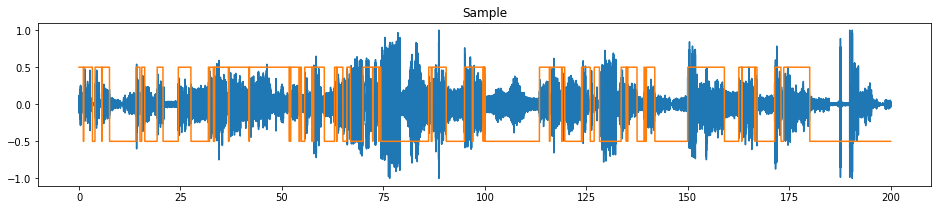

46 % voice 54 % silence


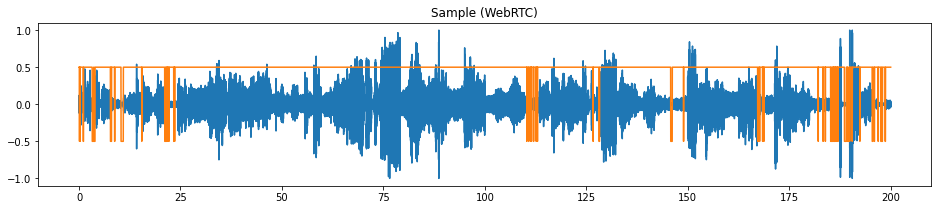

In [8]:
import matplotlib.pyplot as plt

class DataGenerator:
    
    def __init__(self, data, size_limit=0):        
        self.data = data
        self.size = size_limit if size_limit > 0 else len(data['labels'])
        self.data_mode = 0
        
    def set_noise_level_db(self, level, reset_data_mode = True):
        
        if level not in noise_levels_db:
            raise Exception(f'Noise level "{level}" not supported! Options are: {list(noise_levels_db.keys())}')
        
        self.noise_level = level
        
        # переключатель режима подсета и позиции
        if reset_data_mode:
            if self.data_mode == 0:
                self.use_train_data()
            elif self.data_mode == 1:
                self.use_validate_data()
            elif self.data_mode == 2:
                self.use_test_data()
        
    def setup_generation(self, frame_count, step_size, batch_size, val_part=0.1, test_part=0.1):
        
        self.frame_count = frame_count
        self.step_size = step_size
        self.batch_size = batch_size
        
        # задаем индексы и размеры подсетов
        self.train_index = 0
        self.val_index = int((1.0 - val_part - test_part) * self.size)
        self.test_index = int((1.0 - test_part) * self.size)
        
        self.train_size = self.val_index
        self.val_size = self.test_index - self.val_index
        self.test_size = self.size - self.test_index
        
    def use_train_data(self):
        
        # считаем, сколько батчей мы можем собрать с данными параметрами
        n = int((self.train_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.train_index
        self.data_mode = 0
        
    def use_validate_data(self):
        
        n = int((self.val_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.val_index
        self.data_mode = 1
        
    def use_test_data(self):
        
        n = int((self.test_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.test_index
        self.data_mode = 2

    def get_data(self, index_from, index_to):
        frames = self.data['frames-' + self.noise_level][index_from : index_to]
        mfcc = self.data['mfcc-' + self.noise_level][index_from : index_to]
        delta = self.data['delta-' + self.noise_level][index_from : index_to]
        labels = self.data['labels'][index_from : index_to]
        return frames, mfcc, delta, labels
        
    def get_batch(self, index):
        
        # текущая позиция в длинном файле.
        pos = self.initial_pos + (self.batch_size * index) * self.step_size
        
        # собираем необходимые данные.
        l = self.frame_count + self.step_size * self.batch_size
#         print(pos, l)
        frames, mfcc, delta, labels = self.get_data(pos, pos + l)
#         print(frames.shape, mfcc.shape, delta.shape, labels.shape)
        
        x, y, i = [], [], 0
        
        # собираем батчи
        while len(y) < self.batch_size:
            
            X = np.hstack((mfcc[i : i + self.frame_count], delta[i : i + self.frame_count]))
            
            # список фреймов
            x.append(X)
            
            # Лейблом последовательности задаем значение из середины этого лейбла
            y_range = labels[i : i + self.frame_count]
            y.append(int(y_range[int(self.frame_count / 2)]))
            
            
            # Передвигаем окно
            i += self.step_size
        
#         print(np.array(x).shape, np.array(y).shape)
        
        return x, y
        
    def plot_data(self, index_from, index_to, show_track=False):
        
        frames, mfcc, delta, labels = self.get_data(index_from, index_to)
        
        Vis.plot_sample(frames, labels)
        Vis.plot_sample_webrtc(frames)
        
        
# Test
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-15')
generator.use_train_data()
X, y = generator.get_batch(0)

print(f'Load a few frames into memory:\n{X[0]}\n\nCorresponding label: {y[0]}')

generator.plot_data(20000, 40000)

# КОММЕНТАРИЙ
Данная реализация лоадера фиксированная и конечная (из ограниченного числа данных нарезается ограниченное число фреймов, из которых складывается ограниченное число батчей). С учетом того, что у нас данные уже "заморожены" в hdf5, да и датасет достаточно маленький, это рабочая схема, но удобнее иметь бесконечный генератор фреймов, который можно ограничить искусственно, остановив генерацию по достижению определенного этапа (например, 1024 трейновых батча на эпоху). Такой генератор реализован в `dynamic_flow/data_generator.py`. Он бесконечно итерируется по указанным датасетам, доставая из них рандомные куски рандомных файлов, смешивая их по параметрам из DatasetLoader, и останавливается снаружи по параметру batch_count.

# Гиперпараметры тренировки

`FRAMES` задает количество фреймов $\{f_{0}, f_{1}, \ldots ,f_{n}\}$, используемых для предсказания фрейма $f_{n}$.<br/>
`FEATURES` не может превышать количество фичей mfcc+delta (в данном случае 12 + 12)<br/>
`STEP_SIZE` задает, насколько смещается окно по данным в каждой итерации. Маленькое значение дает больше данных, но и больше времени тренировки

In [9]:
BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6
MAX_EPOCHS = 15

# Архитектура сети

# DenseNet

DenseNet - сверточная сеть с резидуалами не через слой, а со всех слоев во все. Так как она не содержит LSTM слоев, то в данной постановке задачи наиболее хорошо отвечает требованиям (не вносит дополнительную задержку из-за реккурентных слоев). Достаточно широко известная архитектура, преимуществами которой являются меньшее затухание градиента, низкая сложность и бОльшее разнообразие фичей. В зависимости от параметров, его можно увеличить, но для сравнимости с бейзлайном архитектура построена так, чтобы размер сети был приблизительно равен размеру бейзлайна. Статья здесь - https://arxiv.org/pdf/1608.06993.pdf (Densely Connected Convolutional Networks, Gao Huang et al)

In [11]:
class DenseSingle(nn.Module):

    def __init__(self, input_size, output_size, dropout, dilation, padding, kernel_size, stride):
        super(DenseSingle, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=padding, 
                      stride=stride, dilation=dilation, bias=False),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        out = self.layer(x)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    
    def __init__(self, input_size, n_layers, growth_rate, dropout, dilation, padding, kernel_size, stride):
        super(DenseBlock, self).__init__()
        
        layers = []
        for i in range(n_layers):
            layers.append(DenseSingle(input_size + i * growth_rate, growth_rate, 
                                      dropout, dilation, padding, kernel_size, stride))
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):        
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(TransitionBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(output_size),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        return self.layers(x)
    
class DenseNet(nn.Module):
    def __init__(self, large=False):
        super(DenseNet, self).__init__()

        if large:
            
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=48, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(48),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=80, output_size=48, dropout=dropout)

            self.dense2 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=80, out_channels=80, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(80),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(80, 2, bias=False)

            
        else:
        
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=24, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(24),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=42, output_size=24, dropout=dropout)

            self.dense2 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=42, out_channels=42, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(42),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(42, 2, bias=False)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        
        x = self.cnn_in(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.cnn_out(x)
        
        x = x.view(BATCH_SIZE, -1)
     
        return F.softmax(self.out(x), dim=1)

# set_seed()
densenet = DenseNet(large=True)
# num_params(densenet)
print(densenet)

DenseNet(
  (cnn_in): Sequential(
    (0): Conv1d(24, 48, kernel_size=(6,), stride=(1,), dilation=(4,), bias=False)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.4, inplace=False)
  )
  (dense1): DenseBlock(
    (block): Sequential(
      (0): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(48, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Dropout(p=0.4, inplace=False)
        )
      )
      (1): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(52, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

проверим поток данных через сетку

In [12]:
generator = DataGenerator(data)
generator.setup_generation(frame_count=FRAMES, step_size=STEP_SIZE, batch_size=BATCH_SIZE)
generator.use_train_data()
generator.set_noise_level_db('None')

print(generator.batch_count, 'training batches were found.')

def accuracy(out, y):
    '''
    Calculate accuracy of model
    '''
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)

temp, OBJ_CUDA = OBJ_CUDA, False
densenet, OBJ_CUDA = DenseNet(large=True), temp
del temp

for i in range(3):
    
    X, y = generator.get_batch(i)
    X = torch.from_numpy(np.array(X)).float().cpu()
    y = torch.from_numpy(np.array(y)).cpu()

    out = densenet(X)
    acc = accuracy(out, y).data.numpy()

print('Successfully ran the network!\n\nExample output:', out.data.numpy()[0])

252 training batches were found.
Successfully ran the network!

Example output: [0.8540022  0.14599784]


# КОММЕНТАРИЙ
На собеседовании с Виталием обсуждали очень примерно архитектуру сетки из нескольких сверток и GRU слоев как потенциальное решение для ВАДа. Изначально хотелось реализовать именно ее, и я даже смог найти описание похожей реализации (статья лежит в корне репозитория). Но, к сожалению, мне не удалось ее натренировать - вероятно, собранные данные не подходят для такой архитектуры, либо я где-то ошибся в реализации слоев. Тем не менее, реализация лежит в `dynamic_flow/models.py`, класс ConvGRU. Так же я смотрел в сторону чуть более продвинутых архитектур, типа Self-attention трансформеров, но так как времени у меня не хватило даже на отладку cGRU, то я просто положил примерный код в тот же файл (код реализован по статье Self-Attentive VAD: Context-Aware Detection of Voice from Noise, Yong Rae Jo et al, 2021, https://ieeexplore.ieee.org/document/9413961). В итоге в той же статье про convGRU я подсмотрел DenseNet с Focal Loss, и реализовал эту архитектуру как основную.

### Focal Loss


Focal loss является разновидностью кросс-энтропийного лосса с множителем $(1-p)^{\gamma}$

$FL(p_t) = -(1-p_t)^{\gamma}~\log(p_t)$

где $p_t$ - вероятность ground truth. Для $\gamma > 0$, the loss for well-classified samples is reduced, which in turn forces the optimizer to pay more attention to badly-classified samples. In the context of our study, FL serves to gradually decrease influence of easy samples (typically samples with little background noise) during training.

Для $\gamma > 0$ лосс верно классифицированных сэмплов уменьшается, что заставляет классификатор уделять больше внимания неверно классифицированным. Здесь focal loss нужен, чтобы уменьшать влияние простых семплов (с низким уровнем шума, например).

Статья по FL - https://arxiv.org/abs/1708.02002, код отсюда https://github.com/clcarwin/focal_loss_pytorch

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Тренировка

`train_net` прогоняет сетку, используя данные, генерируемые  `DataGenerator`.<br/>

In [14]:
import torch.optim as optim
from IPython.display import clear_output
import time

NOISE_LEVELS = ['None', '-15', '-3']

def net_path(epoch, title):
    part = os.getcwd() + '/models/' + title
    if epoch >= 0:
        return part + '_epoch' + str(epoch).zfill(3) + '.net'
    else:
        return part + '.net'

def save_net(net, epoch, title = 'net'):
    if not os.path.exists(os.getcwd() + '/models'):
        os.makedirs(os.getcwd() + '/models')
    torch.save(net, net_path(epoch, title))
    
def load_net(epoch = MAX_EPOCHS-1, title = 'cGRU'):
    if OBJ_CUDA:
        return torch.load(net_path(epoch, title))
    else:
        return torch.load(net_path(epoch, title), map_location='cpu')

def train_net(net, data, size_limit = 0, noise_level = 'None', epochs = MAX_EPOCHS, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, use_focal_loss = True, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True):

    
    # Задаем генератор
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.train_size == 0:
        print('Error: no training data was found!')
        return
    
    if OBJ_CUDA:
        print('cuda ', OBJ_CUDA)
        net.cuda()
        
    # Можно тренировать и на кросс-энтропию
    if use_focal_loss:
        criterion = FocalLoss(gamma)
        levels = NOISE_LEVELS
    else:
        criterion = nn.CrossEntropyLoss()
        levels = [noise_level]
    
    if OBJ_CUDA:
        criterion.cuda()
    
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    if verbose:
        print(net)
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size*3 if use_focal_loss else generator.train_size
        _vlsz = generator.val_size*3 if use_focal_loss else generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        _critstr = f'Focal Loss (γ = {gamma})' if use_focal_loss else f'Cross-Entropy ({noise_level} dB)'
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Criterion: {_critstr}\nOptimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')
    
    net.train()
    stalecount, maxacc = 0, 0
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Строит обновляемые графики лоссов и метрик (если verbose)
        '''
        clear_output(wait=True)
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        
        
    def run(net, optimize = False):
        '''
        Прогон одной эпохи. Фреймы закидываются генераторами по мере необходимости,
        не тратя память. Возвращает средний лосс и accuracy
        '''
        epoch_loss, epoch_acc, level_acc = 0, [], []
        
        #Если мы используем фокал лосс, то нужны все уровни шума
        batches = generator.batch_count
        print('batches in run ', batches)
        num_batches = batches*len(levels)
        print('num_batches in run ', num_batches)
        
        if num_batches == 0:
            raise ValueError('Not enough data to create a full batch!')
        
        # Хелпер для прогона батча
        def run_batch(X, y, epoch_loss, epoch_acc):

            X = Variable(torch.from_numpy(np.array(X)).float())
            y = Variable(torch.from_numpy(np.array(y))).long()

            if OBJ_CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)
#             print('net_out in run_batch', out.shape)

            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # В тренировке считаем бэкпроп и оптимизатор
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if OBJ_CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc
        
        # для всех заданных уровней шума
        for lvl in levels:
            
            # подстраиваем генератор под уровень шума
            generator.set_noise_level_db(lvl)
            
            for i in range(batches):

                X, y = generator.get_batch(i)
#                 print('get_batch_train/val ', np.array(X).shape, np.array(y).shape)
                temp_loss, temp_acc = run_batch(X, y, epoch_loss, epoch_acc)
                epoch_loss += temp_loss / float(num_batches)
                level_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(level_acc)
    
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    # итерируемся по всем эпохам
    for epoch in range(epochs):
        
        # считаем лосс и accuracy для эпохи и оптимизируем по ним
        generator.use_train_data()
        loss, acc = run(net, optimize=True)
        print(loss, loss)
        losses.append(loss)
        accs.append(acc)
        
        # Если генератор валидации не кончился, считаем метрики валидации
        if generator.val_size != 0:
            net.eval()
            generator.use_validate_data()
            val_loss, val_acc = run(net)
            print(val_loss, val_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            net.train()
            
            # Если задан early stop, то чекаем, не застряла ли accuracy валидации, иначе останавливаем
           
            if epoch > 0 and val_accs[-1] <= maxacc:
                stalecount += 1
                if stalecount > patience and early_stopping:
                    return
            else:
                stalecount = 0
                maxacc = val_accs[-1]
        
        if auto_save:
            save_net(net, epoch, title)
        
        # Строим график метрик, если надо
        if verbose:             
            plot(losses, accs, val_losses, val_accs)

# КОММЕНТАРИЙ
Как я уже говорил, моя реализация реал-тайм подгрузки и аугментации не позволяет быстро тренировать сеть, которой нужен батч размером 2048, а на меньших батчах учить достаточно бессмысленно (сеть сходится еле-еле, у меня не хватило терпения и времени дождаться каких-то адекватных результатов). В целом, тренировку можно запустить с помощью `dynamic_flow/train.py` (перед этим прописав правильные пути до датасетов в `config/config.py` и положив папки с лейблами в корень либриспича), пайплайн работает, но результатов на нем я не успел получить. 

### Сид генерации

Для повторимости экспериментов задаем сиды для торча и нампая

In [15]:
def set_seed(seed = 666):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if OBJ_CUDA:
        torch.cuda.manual_seed_all(seed)

# Метрики

### ROC кривая
Считаем ROC и AUC по всем шумам на тест-сете из генератора

In [16]:
from sklearn import metrics

def test_predict(net, data, size_limit, noise_level):
    '''
    Вычисляет предсказания на тесте
    '''
    
    # Датагенератор со стандартными параметрами
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []
#     print('batches in test_predict ', generator.batch_count)

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()
#         print('batches shape in test_predict ', X.shape, y.shape)

        if OBJ_CUDA:
            X = X.cuda()

        out = net(X)
        
#         print('net out in test_predict ', out.shape)

        if OBJ_CUDA:
            out = out.cpu()
            y = y.cpu()

        #ground-truth лейблы
        y_true.extend(y.data.numpy())

        # Насчитанные сеткой вероятностные лейблы
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score
    


def roc_auc(net, data, noise_lvl, size_limit = 0):
    plt.figure(1, figsize=(16, 10))
    plt.title('Receiver Operating Characteristic (%s)' % noise_lvl, fontsize = 16)
    print('roc_auc')
        
    # предсказания
    y_true, y_score = test_predict(net, data, size_limit, noise_lvl)

    # считаем ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc_res = metrics.auc(fpr, tpr)

    # строим 
    plt.plot(fpr, tpr, label='(AUC = %0.3f)' % (auc_res))

#     plt.xlim([0, 0.2])
#     plt.ylim([0.6, 1])
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right', prop={'size': 16})
    plt.show()

### Подсчет порогов
Считаем заданные в ТЗ пороги - первый для FA=1%, второй для FR=1% и третий FA=FR

In [ ]:
# !pip install bob

In [36]:
from sklearn.metrics import confusion_matrix
import math

def reject_metrics(net, data, size_limit = 0, frr = 1, far = 1, plot = True):
    lvls = {'None': 'no noise', '-15': 'low noise', '-3': 'high noise'}
    '''
    Computes the confusion matrix for a given network.
    '''
    
    # Применяем трешхолды к предиктам
    def apply_threshold(y_score, t = 0.5):
        return [1 if y >= t else 0 for idx, y in enumerate(y_score)]
    
    def fix_frr(y_true, y_score, frr_target, noise_level):
        
        # костыль
        if noise_level == 'None':
            t = 1e-4
        elif noise_level == '-15':
            t = 1e-5
        else:
            t = 1e-9
        
        # фиксированный FR
        while t < 1.0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            
            if frr >= frr_target:
                return far, frr, t
            
            t *= 1.1
    
        # Возвращаем самый похожий результат, если нет совпадений
        return far, frr, t
    
    def fix_far(y_true, y_score, far_target):
        
        t = 1.2
        
        # фиксированный FА
        while t > 0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if far >= far_target:
                return frr, far, t
            
            t *= 0.999
    
        return frr, far, t
    
    def eer(y_true, y_score):
        fpr, tpr, threshold = metrics.roc_curve(y_true, y_score, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        return EER, eer_threshold

    print('Network metrics:')

    # для каждого уровня шума
    for lvl in NOISE_LEVELS:
        
        y_true, y_score = test_predict(net, data, size_limit, lvl)
        ffr = fix_frr(y_true, y_score, frr, lvl)
        ffa = fix_far(y_true, y_score, far)
        fafr = eer(y_true, y_score)
        

        
        print(f'FAR: {ffr[0]}% for fixed FRR at {ffr[1]}% with threshhold {ffr[2]} and ', lvls[lvl])
        print(f'FRR: {ffa[0]}%  for fixed FAR at {ffa[1]}% with threshhold {ffa[2]} and ', lvls[lvl])
        print(f'EER: {fafr[0]*100}% with threshhold {fafr[1]} and ', lvls[lvl])

# Подсчет лейбла на рандомном сэмпле из даталоадера

In [18]:
def netvad(net, data, noise_level = '-3', init_pos = 2000, length = 1000, only_plot_net = False):
    '''
    Генерирует сэмпл заданной длинный и прогоняет его через сетку.
    Строит графики оригинального аудио с ground truth лейблом, 
    полученным лейблом, а также лейбл WebRTC для сравнения.
    '''
    
    # инициируем генератор
    generator = DataGenerator(data)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    raw_frames, mfcc, delta, labels = generator.get_data(init_pos, init_pos+length)

    # конвертируем семпл во фреймы
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
        
    # делаем батч из фреймов
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
        
    # предсказываем для каждого фрейма
    offset = 15
    accum_out = [0] * offset
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        

    # паддинг
    if num_frames > 0:
        accum_out = accum_out[:len(accum_out)-(BATCH_SIZE-num_frames)]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)
    
    # обрезаем по границам предсказания
    raw_frames = raw_frames[offset:-offset]
    labels = labels[offset:-offset]
    accum_out = accum_out[offset:]

    print('Displaying results for noise level:', noise_level)
    if not only_plot_net:
        Vis.plot_sample(raw_frames, labels, show_distribution = False)
        Vis.plot_sample_webrtc(raw_frames, sensitivity = 0)
    Vis.plot_sample(raw_frames, accum_out, title = 'Sample (Neural Net)', show_distribution = False)

# Подсчет лейбла на произвольном файле

In [182]:
import soundfile as sf
import python_speech_features
import numpy as np
def vad(net, file):
    '''
    Прогоняет через сетку произвольный файл и считает лейбл. 
    '''
    
    audio, _ = sf.read(file)
    mfcc_window_frame_size=4
    
    
    mfcc = python_speech_features.mfcc(audio, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    mfcc = mfcc[:, 1:]
    length = mfcc.shape[0]
    delta = python_speech_features.delta(mfcc, 2)

    # файл во фреймы
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
     # делаем батч из фреймов   
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
    # предсказываем для каждого фрейма

    accum_out = []
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        

    # подгоняем по размеру
    if num_frames > 0:
        accum_out = accum_out[:num_frames+FRAMES]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)  

    Vis.plot_sample(audio, accum_out, title = file, show_distribution = False)
    
    return(file.split('\\')[-1], list(accum_out))

# Подсчет лейбла WebRTCVAD на произвольном файле
Модифицированная функция из https://github.com/wiseman/py-webrtcvad/blob/master/example.py

In [181]:
import os
import numpy as np
import wave
import webrtcvad
import collections
import contextlib
import sys
import wave

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):

    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):

    labels = []
    labels = np.array([1 if vad.is_speech(frame.bytes, sample_rate) else 0 for frame in frames])

    return labels
        

def vad_webrtc(file):
    
    audio, sample_rate = read_wave(file)
    _audio, _ = sf.read(file)
    vad = webrtcvad.Vad(0)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    labels = vad_collector(sample_rate, 10, 300, vad, frames)

    Vis.plot_sample(_audio, labels, title = file+' WebRTC', show_distribution = False)
    
    return(file.split('\\')[-1], list(labels))

# Тренировка, метрики и результаты на тестовом сете

Если `OBJ_TRAIN_MODELS` включен, прогоняется тренировка. Если выключен - подгружается натренированная модель из path_peer/models/название модели

Затем считаются все заданные выше метрики.


Test set evaluation:
02K1LT2AESAPMSB5OJKQ3MM04YCWUJ.wav

densenet:


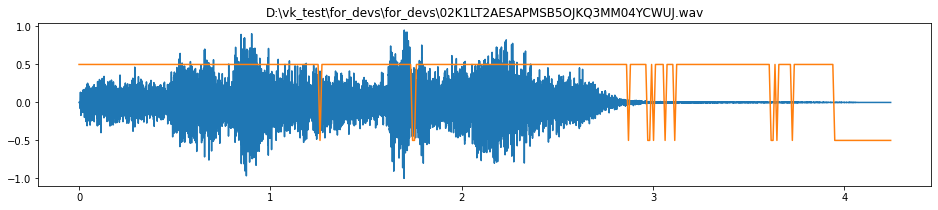


WebRTCVAD


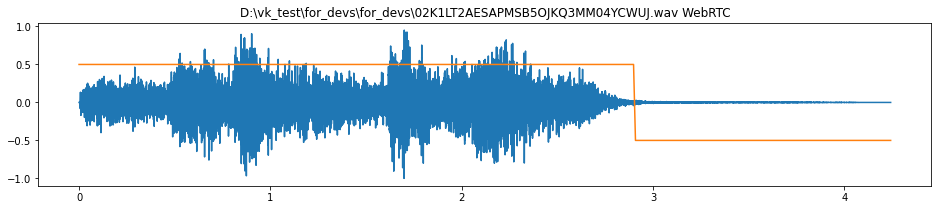

04LED4POXOSGHPULMTP1MSZNWX193O.wav

densenet:


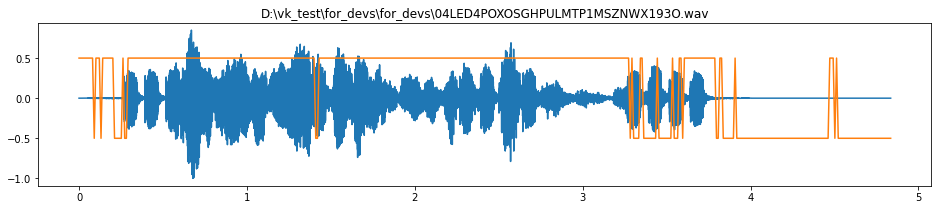


WebRTCVAD


KeyboardInterrupt: 

In [185]:
OBJ_TRAIN_MODELS = False
if OBJ_TRAIN_MODELS:
    
#     set_seed()
#     gru = cGRU()
#     train_net(gru, data, title='cGRU', gamma=2)
    

    set_seed()
    densenet = DenseNet(large=True)
    train_net(densenet, data, title='DenseNet', gamma=2)
    
    
else:
    
#     gru = load_net(title='cGRU')
    densenet = load_net(title='densenet')



print('\nROC Curves:')


roc_auc(densenet, data, 'None')
roc_auc(densenet, data, '-15')
roc_auc(densenet, data, '-3')


print('\nTresholds:')


print('\nDenseNet:')
reject_metrics(densenet, data, frr=1, far=1)


print('\nQualitative results:')


print('\ndensenet:')
netvad(densenet, data, only_plot_net=True)


print('\nTest set evaluation:')

test_root = r'D:\vk_test\for_devs\for_devs'

for file in os.listdir(test_root):
    print(file)

    print('\ndensenet:')
    to_file = vad(densenet, os.path.join(test_root, file))
    with open(os.path.join(r'D:\vk_test\VAD', test_root.split('\\')[-1]+'.txt'), 'a') as res_file:
        res_file.write(str(to_file))
        res_file.write("\n")
    
    print('\nWebRTCVAD')
    
    to_rtc_file = vad_webrtc(os.path.join(test_root, file))
    with open(os.path.join(r'D:\vk_test\VAD', test_root.split('\\')[-1]+'_webrtc.txt'), 'a') as res_web_file:
        res_web_file.write(str(to_rtc_file))
        res_web_file.write("\n")
              
